In [1]:
# this notebook will implement a two lithology - one sediment type model
# it encodes the assumption that sedimentary rocks contribute nothing to the bedload sediment flux
# (that is, all material eroded from sedimenary rocks is treated as fines)

In [2]:
# start by importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# SET UP GRID ARRAYS
dx = 1
x = np.arange(0, 100, dx)

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_ig = np.zeros(len(x))
beta_ig[:50] = 0.004
beta_sed = np.zeros(len(x))
beta_sed[50:] = 0.098

# erodibility values
k_ig = np.zeros(len(x))
k_ig[:50] = 0.0001
k_sed = np.zeros(len(x))
k_sed[50:] = 0.001

In [4]:
# write a function that has two bedrock lithologies in the domain, but only one contributing sediment to bedload
def two_lith_one_sed(x,
                     dx,
                     beta_ig,
                     beta_sed,
                     k_ig,
                     k_sed,
                     c = 1,
                     Hstar = 0.1,
                     baselevel_rate = 0.01,
                     num_steps = 250000, 
                     porosity = 0.55):
    
    H = Hstar + np.zeros(len(x))  # sediment thickness
    H[-1] = 0.0
    etab = -H
    eta = etab + H
    ero = np.zeros(len(x))  # bedrock erosion rate
    q = x  # discharge = distance downstream (first node is left edge of 0th cell)
    qs = np.zeros(len(x))  # first node is left edge of 0th cell
    dt = 0.2 * dx * dx / (c*q[-1])  # time-step size
    t = 0

    for i in range(num_steps):
        
        # lower baselevel
        eta[-1] -= baselevel_rate * dt 
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        # S = 0.001
        
        # calculate e factor
        efac = np.exp(- H / Hstar)
        
        # calculate total bedload sed flux and set boundary condition
        qs[1:] = c * q[1:] * S * (1.0 - efac[:-1])
        qs[0] = 0
        
        # calc bedrock erosion from stream power (plucking)
        ero_plucking_ig = efac[:-1] * (k_ig[1:] * q[1:] * S)
        ero_plucking_sed = efac[:-1] * (k_sed[1:] * q[1:] * S)
        
        # calc bedrock erosion from abrasion
        ero_ab_ig = efac[:-1] * (beta_ig[:-1] * qs[:-1])
        ero_ab_sed = efac[:-1] * (beta_sed[:-1] * qs[:-1])
        
        # calc bedrock erosion rate from stream power and abrasion
        ero[:-1] = ero_plucking_ig + ero_plucking_sed + ero_ab_ig + ero_ab_sed
        
        # calc change in bedrock elev
        etab[:-1] -= ero[:-1] * dt
        
        # calc grain attrition
        atr = beta_ig[1:] * qs[1:]
        
        # calc change in alluvial thickness
        H[:-1] += -((1 / porosity) * ((np.diff(qs)/dx) + atr - ero_plucking_ig)) * dt
        
        # update elev
        eta[:-1] = etab[:-1] + H[:-1]
        
        if t <= num_steps:
            plt.plot(x, H)
        else:
            break
            
        t += (50000 * dt)
        
    return efac, S, qs, eta, etab, ero_plucking_ig, ero_plucking_sed, ero_ab_ig, ero_ab_sed, ero, atr, H

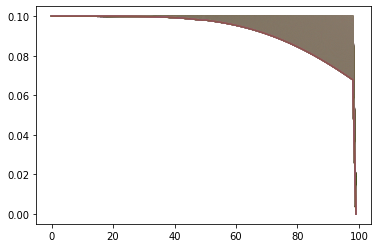

In [5]:
efac, S, qs, eta, etab, ero_plucking_ig, ero_plucking_sed, ero_ab_ig, ero_ab_sed, ero, atr, H = two_lith_one_sed(x,
                                                                                                           dx,
                                                                                                           beta_ig,
                                                                                                           beta_sed,
                                                                                                           k_ig,
                                                                                                           k_sed)

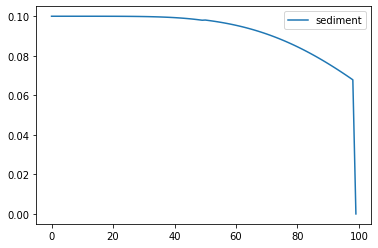

In [6]:
# plt.plot(x, eta, label = 'total elevation')
# plt.plot(x, etab, label = 'bedrock')
plt.plot(x, H, label = 'sediment')
plt.legend()
plt.show()

(0, 1)

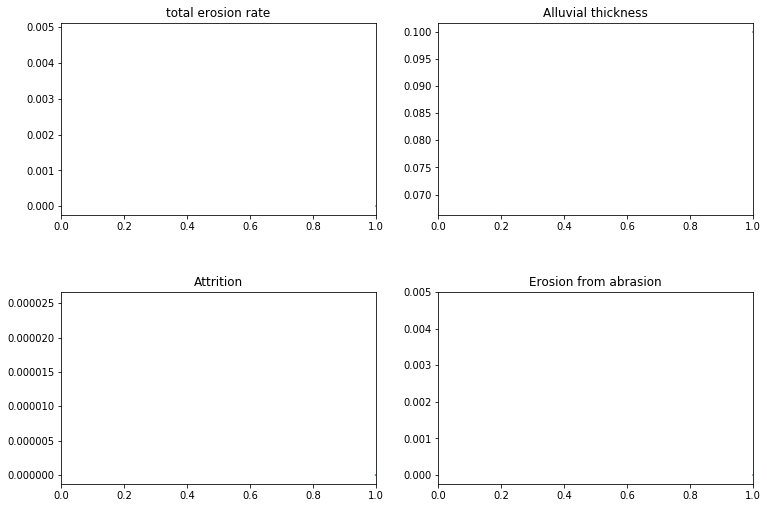

In [7]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (12, 8))
# fig.tight_layout(pad=3.0)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

ax1.plot(x[1:], ero[:-1])
ax1.set_title('total erosion rate')
# ax1.yaxis.set_ticklabels([])
ax1.set_xlim(0, 1)

ax2.plot(x[1:], H[:-1])
ax2.set_title('Alluvial thickness')
# ax2.yaxis.set_ticklabels([])
ax2.set_xlim(0, 1)

ax3.plot(x[1:], atr)
ax3.set_title('Attrition')
# ax3.yaxis.set_ticklabels([])
ax3.set_xlim(0, 1)

ax4.plot(x[1:], ero_ab_ig + ero_ab_sed)
ax4.set_title('Erosion from abrasion')
# ax4.yaxis.set_ticklabels([])
ax4.set_xlim(0, 1)

In [8]:
qs

array([0.00000000e+00, 2.05387633e-09, 9.36381259e-09, 2.77781346e-08,
       6.67843457e-08, 1.40845299e-07, 2.71001544e-07, 4.86754265e-07,
       8.28238938e-07, 1.34869507e-06, 2.11723228e-06, 3.22188764e-06,
       4.77296362e-06, 6.90663059e-06, 9.78877215e-06, 1.36190466e-05,
       1.86351329e-05, 2.51171240e-05, 3.33920287e-05, 4.38383367e-05,
       5.68906013e-05, 7.30439899e-05, 9.28587540e-05, 1.16964567e-04,
       1.46064678e-04, 1.80939837e-04, 2.22451941e-04, 2.71547352e-04,
       3.29259858e-04, 3.96713226e-04, 4.75123327e-04, 5.65799796e-04,
       6.70147207e-04, 7.89665761e-04, 9.25951458e-04, 1.08069577e-03,
       1.25568478e-03, 1.45279791e-03, 1.67400605e-03, 1.92136937e-03,
       2.19703460e-03, 2.50323200e-03, 2.84227199e-03, 3.21654144e-03,
       3.62849977e-03, 4.08067486e-03, 4.57565880e-03, 5.11610367e-03,
       5.70471728e-03, 6.34425900e-03, 7.06316143e-03, 7.70469090e-03,
       8.39496722e-03, 9.13509824e-03, 9.92615786e-03, 1.07691764e-02,
      

In [9]:
efac

array([0.36787945, 0.36787946, 0.36787948, 0.36787954, 0.36787964,
       0.3678798 , 0.36788006, 0.36788047, 0.36788107, 0.36788194,
       0.36788317, 0.36788487, 0.36788718, 0.36789027, 0.36789433,
       0.3678996 , 0.36790636, 0.36791494, 0.36792571, 0.3679391 ,
       0.36795561, 0.36797579, 0.36800029, 0.3680298 , 0.36806512,
       0.36810712, 0.36815678, 0.36821515, 0.36828341, 0.36836284,
       0.36845481, 0.36856083, 0.36868252, 0.36882162, 0.36898001,
       0.36915969, 0.36936279, 0.36959161, 0.36984854, 0.37013617,
       0.3704572 , 0.3708145 , 0.37121111, 0.3716502 , 0.37213513,
       0.37266942, 0.37325679, 0.37390111, 0.37460647, 0.37535895,
       0.37500746, 0.37576623, 0.37657417, 0.37743409, 0.37834871,
       0.37932073, 0.38035281, 0.38144754, 0.38260749, 0.3838352 ,
       0.38513317, 0.38650386, 0.3879497 , 0.3894731 , 0.39107642,
       0.39276201, 0.39453216, 0.39638914, 0.39833519, 0.40037251,
       0.40250326, 0.40472957, 0.40705352, 0.40947717, 0.41200

In [10]:
ero_plucking_ig

array([1.19530820e-13, 5.44952119e-13, 1.61662303e-12, 3.88669498e-12,
       8.19687520e-12, 1.57716829e-11, 2.83280400e-11, 4.82017894e-11,
       7.84914604e-11, 1.23219310e-10, 1.87509361e-10, 2.77781850e-10,
       4.01963190e-10, 5.69710256e-10, 7.92647525e-10, 1.08461533e-09,
       1.46192732e-09, 1.94363494e-09, 2.55179669e-09, 3.31174992e-09,
       4.25238256e-09, 5.40640267e-09, 6.81060344e-09, 8.50612164e-09,
       1.05386875e-08, 1.29588647e-08, 1.58222789e-08, 1.91898346e-08,
       2.31279189e-08, 2.77085938e-08, 3.30097762e-08, 3.91154080e-08,
       4.61156182e-08, 5.41068782e-08, 6.31921555e-08, 7.34810686e-08,
       8.50900472e-08, 9.81425045e-08, 1.12769026e-07, 1.29107583e-07,
       1.47303776e-07, 1.67511121e-07, 1.89891381e-07, 2.14614957e-07,
       2.41861350e-07, 2.71819705e-07, 3.04689446e-07, 3.40681025e-07,
       3.80016791e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [11]:
S

array([3.24918453e-09, 7.40666689e-09, 1.46481217e-08, 2.64128239e-08,
       4.45628103e-08, 7.14530622e-08, 1.10004952e-07, 1.63782104e-07,
       2.37067741e-07, 3.34942538e-07, 4.63361932e-07, 6.29231844e-07,
       8.40481730e-07, 1.10613391e-06, 1.43636812e-06, 1.84258039e-06,
       2.33743513e-06, 2.93490989e-06, 3.65033177e-06, 4.50040503e-06,
       5.50322931e-06, 6.67830821e-06, 8.04654788e-06, 9.63024559e-06,
       1.14530685e-05, 1.35400226e-05, 1.59174126e-05, 1.86127930e-05,
       2.16549109e-05, 2.50736422e-05, 2.88999212e-05, 3.31656652e-05,
       3.79036952e-05, 4.31476541e-05, 4.89319234e-05, 5.52915408e-05,
       6.22621184e-05, 6.98797658e-05, 7.81810162e-05, 8.72027606e-05,
       9.69821892e-05, 1.07556743e-04, 1.18964076e-04, 1.31242030e-04,
       1.44428630e-04, 1.58562084e-04, 1.73680811e-04, 1.89823490e-04,
       2.07029121e-04, 2.26151050e-04, 2.41718678e-04, 2.58623747e-04,
       2.76472896e-04, 2.95258275e-04, 3.14972736e-04, 3.35609606e-04,
      

In [12]:
ero

array([1.19530820e-13, 3.56726776e-12, 1.53956412e-11, 4.47627244e-11,
       1.06471278e-10, 2.23028245e-10, 4.27112299e-10, 7.64471333e-10,
       1.29726516e-09, 2.10786153e-09, 3.30308584e-09, 5.01891671e-09,
       7.42561170e-09, 1.07332389e-08, 1.51975824e-08, 2.11263824e-08,
       2.88858629e-08, 3.89074952e-08, 5.16949395e-08, 6.78311021e-08,
       8.79852453e-08, 1.12920083e-07, 1.43498796e-07, 1.80691906e-07,
       2.25583939e-07, 2.79379834e-07, 3.43411036e-07, 4.19141230e-07,
       5.08171694e-07, 6.12246229e-07, 7.33255672e-07, 8.73241971e-07,
       1.03440185e-06, 1.21909010e-06, 1.42982247e-06, 1.66927832e-06,
       1.94030301e-06, 2.24591016e-06, 2.58928382e-06, 2.97378077e-06,
       3.40293291e-06, 3.88045005e-06, 4.41022311e-06, 4.99632800e-06,
       5.64303025e-06, 6.35479068e-06, 7.13627227e-06, 7.99234838e-06,
       8.92811270e-06, 1.37698887e-05, 2.64199307e-04, 2.88779405e-04,
       3.15328092e-04, 3.43911739e-04, 3.74598128e-04, 4.07456253e-04,
      

In [13]:
H

array([0.1       , 0.1       , 0.09999999, 0.09999997, 0.09999995,
       0.0999999 , 0.09999983, 0.09999972, 0.09999956, 0.09999932,
       0.09999898, 0.09999852, 0.09999789, 0.09999705, 0.09999594,
       0.0999945 , 0.09999266, 0.09999032, 0.09998739, 0.09998374,
       0.09997924, 0.09997374, 0.09996707, 0.09995903, 0.09994941,
       0.09993797, 0.09992446, 0.09990857, 0.09989   , 0.09986839,
       0.09984338, 0.09981456, 0.09978149, 0.0997437 , 0.0997007 ,
       0.09965194, 0.09959685, 0.09953483, 0.09946523, 0.09938739,
       0.09930058, 0.09920405, 0.09909701, 0.09897865, 0.0988481 ,
       0.09870447, 0.09854681, 0.09837415, 0.09818548, 0.09798461,
       0.09807858, 0.09787627, 0.09766131, 0.09743303, 0.0971908 ,
       0.09693403, 0.09666211, 0.09637451, 0.09607067, 0.0957501 ,
       0.0954123 , 0.09505683, 0.09468323, 0.0942911 , 0.09388007,
       0.09344977, 0.09299988, 0.09253009, 0.09204013, 0.09152977,
       0.09099878, 0.09044698, 0.08987422, 0.08928037, 0.08866